<a href="https://colab.research.google.com/github/niuhaoyu16/Pytorch/blob/master/Pytorch_NN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from pathlib import Path
import requests
import pickle
import gzip

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"

FILENAME = "mnist.pkl.gz"

if not (PATH /FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)
    

In [0]:
with gzip.open((PATH /FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")
    

(50000, 784)


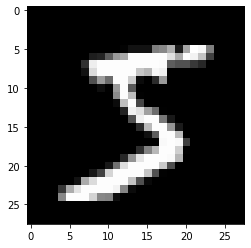

In [4]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28,28)), cmap="gray")
print(x_train.shape)

In [8]:
import torch
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

n, c =x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())



tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
import math
weights = torch.randn(784,10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [0]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

In [11]:
bs = 64

xb = x_train[0:bs]
preds = model(xb)
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.0926, -2.1379, -2.8620, -2.4686, -2.6450, -2.3472, -1.5950, -2.5691,
        -2.8531, -2.1799], grad_fn=<SelectBackward>) torch.Size([64, 10])


In [0]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [14]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3599, grad_fn=<NegBackward>)


In [0]:
def accuracy(out, yb):
  preds = torch.argmax(out, dim=1)
  return (preds == yb).float().mean()

In [16]:
print(accuracy(preds, yb))

tensor(0.1562)


In [0]:
from IPython.core.debugger import set_trace
lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for
for epoch in range(epochs):
  for i in range((n-1) // bs +1):
    start_i = i * bs
    end_i = start_i + bs
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]
    pred = model(xb)
    loss = loss_func(pred, yb)

    loss.backward()
    with torch.no_grad():
      weights -= weights.grad * lr
      bias -= bias.grad * lr
      weights.grad.zero_()
      bias.grad.zero_()



In [20]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0639, grad_fn=<NegBackward>) tensor(1.)


In [0]:
import torch.nn.functional as F
loss_func = F.cross_entropy

def mdoel(xb):
  return xb @ weights + bias

In [23]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0639, grad_fn=<NllLossBackward>) tensor(1.)


In [0]:
from torch import nn

class Mnist_Logistic(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(784,10) / math.sqrt(784))
    self.bias = nn.Parameter(torch.zeros(10))

  def forward(self, xb):
    return xb @ self.weights + self.bias


In [0]:
model = Mnist_Logistic()

In [28]:
print(loss_func(model(xb), yb))

tensor(2.5136, grad_fn=<NllLossBackward>)


In [0]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

In [42]:
print(loss_func(model(xb), yb))

tensor(0.0815, grad_fn=<NllLossBackward>)


In [0]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

In [44]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.2301, grad_fn=<NllLossBackward>)


In [0]:
fit()

In [46]:
print(loss_func(model(xb), yb))

tensor(0.0824, grad_fn=<NllLossBackward>)


In [0]:
from torch import optim

In [0]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

In [0]:
model, opt = get_model()

In [50]:
print(loss_func(model(xb), yb))

tensor(2.3392, grad_fn=<NllLossBackward>)


In [51]:
for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0800, grad_fn=<NllLossBackward>)


In [0]:
from torch.utils.data import TensorDataset

In [0]:
train_ds = TensorDataset(x_train, y_train)

In [0]:
xb,yb = train_ds[i*bs : i*bs+bs]

In [55]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0823, grad_fn=<NllLossBackward>)


In [0]:
from torch.utils.data import DataLoader

In [57]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0817, grad_fn=<NllLossBackward>)


In [58]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0807, grad_fn=<NllLossBackward>)


In [0]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [60]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.2996)
1 tensor(0.3040)


In [0]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [0]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)
        

In [0]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [64]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.385169998216629
1 0.3218842137813568


In [0]:
#CNN



In [0]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1

In [66]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3309145693063736
1 0.2588960606098175


In [0]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

In [68]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.37870964698791504
1 0.24367858080863952


In [0]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [0]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [71]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.36958853442668915
1 0.31356237324476244


In [72]:
print(torch.cuda.is_available())

False
